# Vector Tiles Pipeline

This notebook processes landslide GeoJSON data into vector tiles for web mapping visualization using Tippecanoe and serves them via tileserver-gl.

## Setup and Configuration

In [1]:
# %pip install geopandas shapely pyproj --quiet
import json, pathlib
import geopandas as gpd
from shapely import make_valid
from shapely.geometry import mapping, shape
import numpy as np

In [2]:

# ---- User config ----
INPUT_GEOJSON = "../PostProcessing/final_combined.geojson"   # path to your source GeoJSON
OUTPUT_DIR = "build_tiles"
pathlib.Path(OUTPUT_DIR).mkdir(exist_ok=True)

## Load and Process GeoJSON Data

In [3]:
print("Loading GeoJSON (this can take a while for very large files)...")
try:
    gdf = gpd.read_file(INPUT_GEOJSON)
except Exception as e:
    print("geopandas.read_file() failed, using json fallback → GeoDataFrame.from_features().")
    with open(INPUT_GEOJSON, "r") as f:
        data = json.load(f)
    # If CRS is unknown from file, assume WGS84
    gdf = gpd.GeoDataFrame.from_features(data["features"], crs="EPSG:4326")

Loading GeoJSON (this can take a while for very large files)...


In [6]:
# Ensure CRS = EPSG:4326
print("CRS:", gdf.crs)
if gdf.crs is None or str(gdf.crs).lower() not in ["epsg:4326", "wgs84"]:
    print("Reprojecting to EPSG:4326...")
    gdf = gdf.to_crs(epsg=4326)

# Basic QA
print("Records:", len(gdf))
print("Columns:", list(gdf.columns))
print("Bounds:", gdf.total_bounds)

# Fix invalid geometries
invalid = ~gdf.is_valid
if invalid.any():
    print(f"Fixing {invalid.sum()} invalid geometries with make_valid()...")
    gdf.loc[invalid, "geometry"] = gdf.loc[invalid, "geometry"].apply(make_valid)

# Optional simplify (set > 0 if desired)
SIMPLIFY_TOL = 0.0  # e.g., 0.00005 ≈ ~5 meters
if SIMPLIFY_TOL > 0:
    gdf["geometry"] = gdf.geometry.simplify(SIMPLIFY_TOL, preserve_topology=True)

CRS: EPSG:4326
Records: 148954
Columns: ['YEAR', 'Material', 'SLOPE', 'Shape_Length', 'DEEP_SHAL', 'Cont_details', 'AREA', 'MVMT_AZIMUTH_DEG', 'Study_area', 'Bedrock_type', 'CONFIDENCE', 'Trigger', 'MONTH', 'Shape_Area', 'Latitude', 'Type_details', 'Type', 'Longitude', 'FAIL_DEPTH', 'MOVEMENT', 'Reference', 'Event_verification', 'MAP_UNIT_L', 'DAY', 'Discharge estimate (m3/s)', 'Volume_estimate_method', 'Point_location', 'LANDSLIDE_ID', 'MOVE_CODE', 'FAN_HEIGHT', 'DATE_MOVE', 'DATASET_LINK', 'Resource_road_type', 'REACTIVATION', 'Contributo', 'AVG_SCARP_DIST_FT', 'VOLUME', 'Size_class', 'REF_ID_COD', 'Timing', 'DESCRIPTION', 'NAME', 'ORIGIN', 'Resource_road_activity', 'HS_HEIGHT', 'Watercours', 'Comment', 'DATE_RANGE', 'RELATIVE_AGE', 'VOL', 'GEOL', 'MATERIAL', 'TYPE_MOVE', 'lon', 'lat', 'PGA', 'MMI', 'PGV', 'PSA03', 'unique_id', 'geometry']
Bounds: [-128.3368       41.99594023 -116.0098       51.99353   ]


In [8]:
# Get the count of each geometry type (e.g., Polygon, MultiPolygon)
geometry_counts = gdf.geometry.geom_type.value_counts()
print(geometry_counts)

MultiPolygon          144668
Point                   4240
Polygon                   42
GeometryCollection         4
Name: count, dtype: int64


## Data Quality Checks

<Axes: >

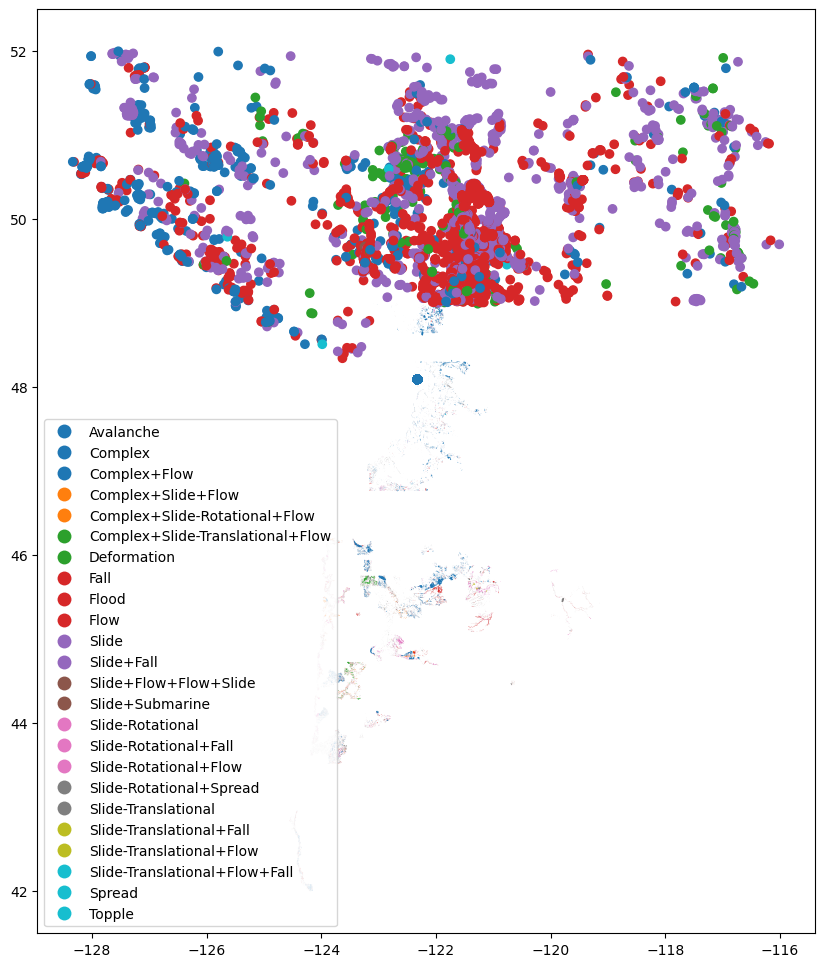

In [9]:
gdf.plot(figsize=(12, 12), column='MOVEMENT', legend=True)

In [10]:
print("DataFrame columns:")
for l in (list(gdf.columns)):
    print("-", l)

DataFrame columns:
- YEAR
- Material
- SLOPE
- Shape_Length
- DEEP_SHAL
- Cont_details
- AREA
- MVMT_AZIMUTH_DEG
- Study_area
- Bedrock_type
- CONFIDENCE
- Trigger
- MONTH
- Shape_Area
- Latitude
- Type_details
- Type
- Longitude
- FAIL_DEPTH
- MOVEMENT
- Reference
- Event_verification
- MAP_UNIT_L
- DAY
- Discharge estimate (m3/s)
- Volume_estimate_method
- Point_location
- LANDSLIDE_ID
- MOVE_CODE
- FAN_HEIGHT
- DATE_MOVE
- DATASET_LINK
- Resource_road_type
- REACTIVATION
- Contributo
- AVG_SCARP_DIST_FT
- VOLUME
- Size_class
- REF_ID_COD
- Timing
- DESCRIPTION
- NAME
- ORIGIN
- Resource_road_activity
- HS_HEIGHT
- Watercours
- Comment
- DATE_RANGE
- RELATIVE_AGE
- VOL
- GEOL
- MATERIAL
- TYPE_MOVE
- lon
- lat
- PGA
- MMI
- PGV
- PSA03
- unique_id
- geometry


## Data Preprocessing

In [11]:
# Rename columns in the GeoDataFrame
gdf = gdf.rename(columns={
    'original_dataset': 'Original_Dataset',
    'unique_id': 'Unique_ID'
})

# Also update the props_df to maintain consistency
props_df = props_df.rename(columns={
    'original_dataset': 'Original_Dataset',
    'unique_id': 'Unique_ID'
})

print("Renamed columns:")
print("- 'original_dataset' → 'Original_Dataset'")
print("- 'unique_id' → 'Unique_ID'")

Renamed columns:
- 'original_dataset' → 'Original_Dataset'
- 'unique_id' → 'Unique_ID'


In [12]:
# ---- Pure-Python GeoJSON writer (no Fiona/pandas writer) ----
CLEANED_GEOJSON = f"{OUTPUT_DIR}/cleaned.geojson"
props_df = gdf.drop(columns="geometry", errors="ignore")
props_df = props_df.replace({np.nan: None})

records = props_df.to_dict("records")

features = []
for geom, props in zip(gdf.geometry, records):
    if geom is None:
        continue
    features.append({
        "type": "Feature",
        "geometry": json.loads(json.dumps(mapping(geom))),
        "properties": props if props is not None else {}
    })

out = {"type": "FeatureCollection", "features": features}
with open(CLEANED_GEOJSON, "w") as f:
    json.dump(out, f)

print("Wrote:", CLEANED_GEOJSON)


Wrote: build_tiles/cleaned.geojson


In [13]:
print(props_df.columns)

Index(['YEAR', 'Material', 'SLOPE', 'Shape_Length', 'DEEP_SHAL',
       'Cont_details', 'AREA', 'MVMT_AZIMUTH_DEG', 'Study_area',
       'Bedrock_type', 'CONFIDENCE', 'Trigger', 'MONTH', 'Shape_Area',
       'Latitude', 'Type_details', 'Type', 'Longitude', 'FAIL_DEPTH',
       'MOVEMENT', 'Reference', 'Event_verification', 'MAP_UNIT_L', 'DAY',
       'Discharge estimate (m3/s)', 'Volume_estimate_method', 'Point_location',
       'LANDSLIDE_ID', 'MOVE_CODE', 'FAN_HEIGHT', 'DATE_MOVE', 'DATASET_LINK',
       'Resource_road_type', 'REACTIVATION', 'Contributo', 'AVG_SCARP_DIST_FT',
       'VOLUME', 'Size_class', 'REF_ID_COD', 'Timing', 'DESCRIPTION', 'NAME',
       'ORIGIN', 'Resource_road_activity', 'HS_HEIGHT', 'Watercours',
       'Comment', 'DATE_RANGE', 'RELATIVE_AGE', 'VOL', 'GEOL', 'MATERIAL',
       'TYPE_MOVE', 'lon', 'lat', 'PGA', 'MMI', 'PGV', 'PSA03', 'Unique_ID'],
      dtype='object')


## Build Vector Tiles with Tippecanoe

In [ ]:
## Old tippecanoe code (commented out)


# MBTILES = "pga_combined.mbtiles"
# LAYER = "landslides"
# ATTRS_TO_KEEP = ["LANDSLIDE_ID","MOVEMENT","CONFIDENCE", "SLOPE", "MATERIAL", "Area", "VOL", "MVMT_AZIMUTH_DEG", "GEOL", "DATE_MOVE", "PGA", ""]

# ATTRS_TO_KEEP = ["Reference", "SLOPE", "MOVEMENT", "TYPE_MOVE", "CONFIDENCE",  "RELATIVE_AGE", "MOVE_CODE", "MATERIAL", "AREA", "VOL", "Original_Dataset", "Unique_ID", "MVMT_AZIMUTH_DEG", "GEOL", "DATE_MOVE", "PGA", "MMI", "PGV", "PSA03"]

# attr_args = []
# for a in ATTRS_TO_KEEP:
#     attr_args.extend(["-y", a])

# tippecanoe_cmd = [
#     "tippecanoe",
#     "-o", MBTILES,
#     "-zg",
#     "--drop-densest-as-needed",
#     "--coalesce",
#     "--coalesce-densest-as-needed",
#     "--read-parallel",
#     "--detect-shared-borders",
#     "--no-tile-size-limit",
#     "--no-feature-limit",
#     "--layer", LAYER,
#     "build_tiles/cleaned.geojson"
# ] + attr_args

# print(" ".join(tippecanoe_cmd))


### Check Tippecanoe Installation

In [18]:
!tippecanoe --version

tippecanoe v2.79.0


See the cookbook at https://github.com/mapbox/tippecanoe for more options

### Generate Vector Tiles with Tippecanoe

This command creates MBTiles optimized for web mapping with proper zoom levels and feature preservation.

In [35]:
%%bash
# Improved Tippecanoe command for preserving points at all zoom levels
# Key changes from your original command:
# Removed --drop-densest-as-needed (this was dropping points!)
# Removed --coalesce and --coalesce-densest-as-needed (can merge points)
# Added --retain-points-multiplier=2 (keeps more points at lower zooms)
# Added --preserve-input-order (maintains original point data)
# Added --extend-zooms-if-still-dropping (ensures points aren't dropped)
# Added --force-feature-limit (overrides automatic feature limits)
# Added --quiet flag to reduce verbose output that overwhelms Jupyter

echo "Starting Tippecanoe tile generation..."

tippecanoe -o landslides.mbtiles \
    --minimum-zoom=0 \
    --maximum-zoom=12 \
    --base-zoom=8 \
    --read-parallel \
    --detect-shared-borders \
    --no-tile-size-limit \
    --no-feature-limit \
    --no-simplification-of-shared-nodes \
    --preserve-input-order \
    --extend-zooms-if-still-dropping \
    --force-feature-limit \
    --retain-points-multiplier=2 \
    --quiet \
    --layer landslides \
    build_tiles/cleaned.geojson \
    -y Reference -y SLOPE -y MOVEMENT -y TYPE_MOVE -y CONFIDENCE \
    -y RELATIVE_AGE -y MOVE_CODE -y MATERIAL -y AREA -y VOL \
    -y Original_Dataset -y Unique_ID -y MVMT_AZIMUTH_DEG \
    -y GEOL -y DATE_MOVE -y PGA -y MMI -y PGV -y PSA03 2>&1

echo "Tippecanoe completed successfully!"

Starting Tippecanoe tile generation...
Tippecanoe completed successfully!
Tippecanoe completed successfully!


## Create Map Style and Server Configuration

Generate the required style.json and configuration files for tileserver-gl.

In [21]:

import json, pathlib
STYLE_DIR = "tileserver"
pathlib.Path(STYLE_DIR).mkdir(exist_ok=True)
STYLE_JSON = STYLE_DIR + "/style.json"

style_json = {
  "version": 8,
  "name": "landslides-style",
  "sources": { "landslides": { "type": "vector", "url": "mbtiles://landslides" } },
  "layers": [
    {"id":"landslides-fill","type":"fill","source":"landslides","source-layer":"landslides",
     "paint":{"fill-color":"#ff8800","fill-opacity":0.45}},
    {"id":"landslides-outline","type":"line","source":"landslides","source-layer":"landslides",
     "paint":{"line-color":"#333333","line-width":0.5}}
  ]
}
with open(STYLE_JSON, "w") as f:
    json.dump(style_json, f, indent=2)
print("Wrote:", STYLE_JSON)
print("Place 'landslides.mbtiles' in the same 'tileserver' folder before launching tileserver-gl.")


Wrote: tileserver/style.json
Place 'landslides.mbtiles' in the same 'tileserver' folder before launching tileserver-gl.


### Move MBTiles to Server Directory

In [34]:
import shutil

# Move the mbtiles file to the tileserver directory
shutil.move("landslides.mbtiles", f"{STYLE_DIR}/landslides.mbtiles")
print(f"Moved landslides.mbtiles to {STYLE_DIR}/")

Moved landslides.mbtiles to tileserver/


### Create Tileserver Configuration

In [22]:
# ---- Create the required config.json for modern tileserver-gl ----
CONFIG_JSON = f"{STYLE_DIR}/config.json"

# This file tells the server to connect your style with your data.
config_data = {
  "options": {
    "paths": {
      "root": "/data"
    }
  },
  "styles": {
    "landslides-style": {
      "style": "style.json"
    }
  },
  "data": {
    "landslides": {
      "mbtiles": "landslides.mbtiles"
    }
  }
}

with open(CONFIG_JSON, "w") as f:
    json.dump(config_data, f, indent=2)

print("Wrote:", CONFIG_JSON)
print("This config file explicitly tells tileserver-gl to use your style.json.")

Wrote: tileserver/config.json
This config file explicitly tells tileserver-gl to use your style.json.


## Serve Tiles

Two choices:

- **Tileserver GL** (renders your vector tiles for Cesium)
- **Martin** (serves raw MVT from PostGIS/PMTiles/MBTiles; useful if you also target MapLibre clients)

We'll spin up **Tileserver GL** by default via Docker Compose. Place `landslides.mbtiles` in the `./tileserver` folder next to `style.json`.


### Create Docker Compose Configuration

In [23]:
docker_compose = """services:
  tileserver:
    image: maptiler/tileserver-gl
    container_name: tileserver_gl
    ports:
      - "8080:8080"
    volumes:
      - ./tileserver:/data
    command: ["--port", "8080", "--public_url", "http://localhost:8080"]
  # martin:
  #   image: ghcr.io/maplibre/martin:latest
  #   container_name: martin_server
  #   ports:
  #     - "3000:3000"
  #   volumes:
  #     - ./tileserver:/data
  #   command: ["--enable-cors", "--listen", "0.0.0.0:3000", "/data/landslidesz.mbtiles"]"""
with open("docker-compose.yml", "w") as f:
    f.write(docker_compose)
print("Wrote docker-compose.yml")

Wrote docker-compose.yml


### Start Tile Server

Launch the Docker container to serve vector tiles at http://localhost:8080

You can start docker-compose in terminal 

In [27]:
!docker-compose up -d

[+] Running 0/1
 ⠋ Container tileserver_gl  Creating                                       0.1s 
[+] Running 0/1
 ⠙ Container tileserver_gl  Starting                                       0.2s 
[+] Running 0/1
 ⠹ Container tileserver_gl  Starting                                       0.3s 
[+] Running 0/1
 ⠸ Container tileserver_gl  Starting                                       0.4s 
[+] Running 1/1
 ✔ Container tileserver_gl  Started                                        0.4s 
